In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [19]:
hidden_dim = 2
batch_size = 60

In [20]:
def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, 28*28))
    y = K.reshape(y, shape=(batch_size, 28*28))
    loss = K.sum(K.square(x-y), axis=-1)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return loss + kl_loss

In [21]:
input_img = Input((28, 28, 1))

encoder_1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
], name='encoder')

x = encoder_1(input_img)
z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

encoder_2 = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

encoder = keras.Model(input_img, encoder_2, name='encoder')

In [22]:
decoder = Sequential([
    Dense(128, activation='relu', input_shape=(hidden_dim,)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(28*28, activation='sigmoid'),
    Reshape((28, 28, 1))
], name='decoder')

In [23]:
vae = keras.Model(input_img, decoder(encoder(input_img)), name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (60, 2)                   235908    
                                                                 
 decoder (Sequential)        (None, 28, 28, 1)         236432    
                                                                 
Total params: 472340 (1.80 MB)
Trainable params: 470804 (1.80 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


In [24]:
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, 
        epochs=5, 
        batch_size=batch_size, 
        shuffle=True)

Epoch 1/5
1000/1000 [==============================] - 4s 3ms/step - loss: 59.2299
Epoch 2/5
1000/1000 [==============================] - 3s 3ms/step - loss: 45.0890
Epoch 3/5
1000/1000 [==============================] - 3s 3ms/step - loss: 43.7722
Epoch 4/5
1000/1000 [==============================] - 3s 3ms/step - loss: 43.0290
Epoch 5/5
1000/1000 [==============================] - 3s 3ms/step - loss: 42.5839


100/100 [==============================] - 0s 575us/step


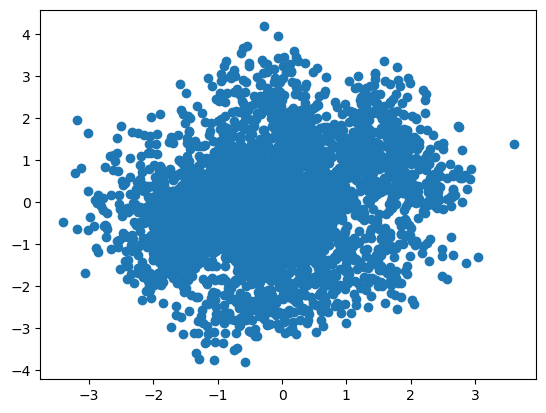

In [25]:
h = encoder.predict(x_test[:6000], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])

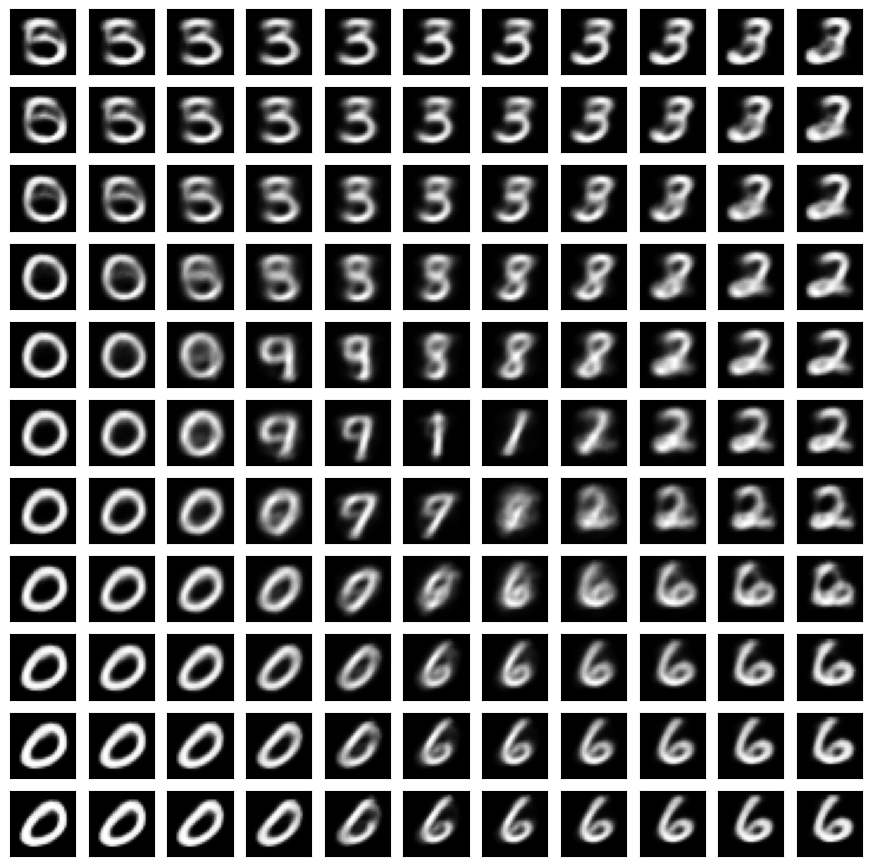

In [26]:
n = 5
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0), verbose=False)
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)